# Part 5: Data-driven model of battery with eDMDc

While the previous data-driven model of the battery created with augmented states in DMDc provided good predictive capabilities, there is room for further improvement. Here we explore the extended DMDc method and demonstrate how to incoporate the trained model in Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz.

## Extended Dynamic Mode Decomposition with control (eDMDc)

Unlike, the previous example where we had to invent relevant features to augment the state with, in eDMDc such features can be created by using known basis functions. For example, if our state is $\mathbf{x}\in \mathbb{R}^n$, a Gaussian basis function with center $\mathbf{c}\in \mathbb{R}^n$, can be of the form

$$
\phi(\mathbf{x, \mathbf{c}}) = \exp \left(  - \frac{||\mathbf{x}-\mathbf{c}||^2} {2 \sigma^2}   \right),
$$

where the parameter $\sigma$ is related to the width of the Gaussian kernel.

By specifying the type and number of basis fucntions to use, one can create a rich basis. For example, using two basis functions of the above type, we would seek to find a dynamics model of the following form:


\begin{align}
\begin{pmatrix}
v_t[k+1] \\ d[k+1] \\ \phi_1[k+1] \\ \phi_2[k+1]
\end{pmatrix} = 
A 
\begin{pmatrix}
v_t[k] \\ d[k]  \\ \phi_1[k] \\ \phi_2[k]
\end{pmatrix} +
B
\left( i[k] \right),
\end{align},

where $\phi_1$ and $\phi_2$ are Gaussian kernels. The parameters of the basis functions, $\sigma$ and $\mathbf{c}$, can be provided by the user or estimated by the training algorithm. We will use the `pykoopman` package, which distributes the centers $\mathbf{c}$ uniformly within the training data.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings

warnings.filterwarnings("ignore", category=np.ComplexWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

We utilise the `pykoopman` package for eDMDc.

In [9]:
import pykoopman as pk

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_train, d_train]).T
control_data = curr_train.reshape((curr_train.size, 1))

edmdc = pk.regression.EDMDc()
kernel_width = 1.0
RBF = pk.observables.RadialBasisFunction(
    rbf_type="gauss",
    n_centers=10,
    centers=None,
    kernel_width=kernel_width,
    polyharmonic_coeff=1.0,
    include_state=True,
)

model = pk.Koopman(observables=RBF, regressor=edmdc)
model.fit(state_data, u=control_data)

Koopman(observables=RadialBasisFunction(centers=array([[3.42456252, 3.04751473, 3.82437831, 2.97457761, 4.19995   ,
        3.45040335, 3.69656523, 3.3425108 , 3.55999724, 2.90122484],
       [2.41552593, 2.59012   , 2.03106336, 2.31109948, 1.91817204,
        1.98675384, 0.50990934, 0.35188005, 1.44341917, 0.        ]])),
        regressor=EDMDc())

We can now simulate the model, initialising the model at the initial values of the state measurements, and see how its predictions compare with the experiment data.

RMS: error: [0.029466804807055616, 0.00021002346606091964]


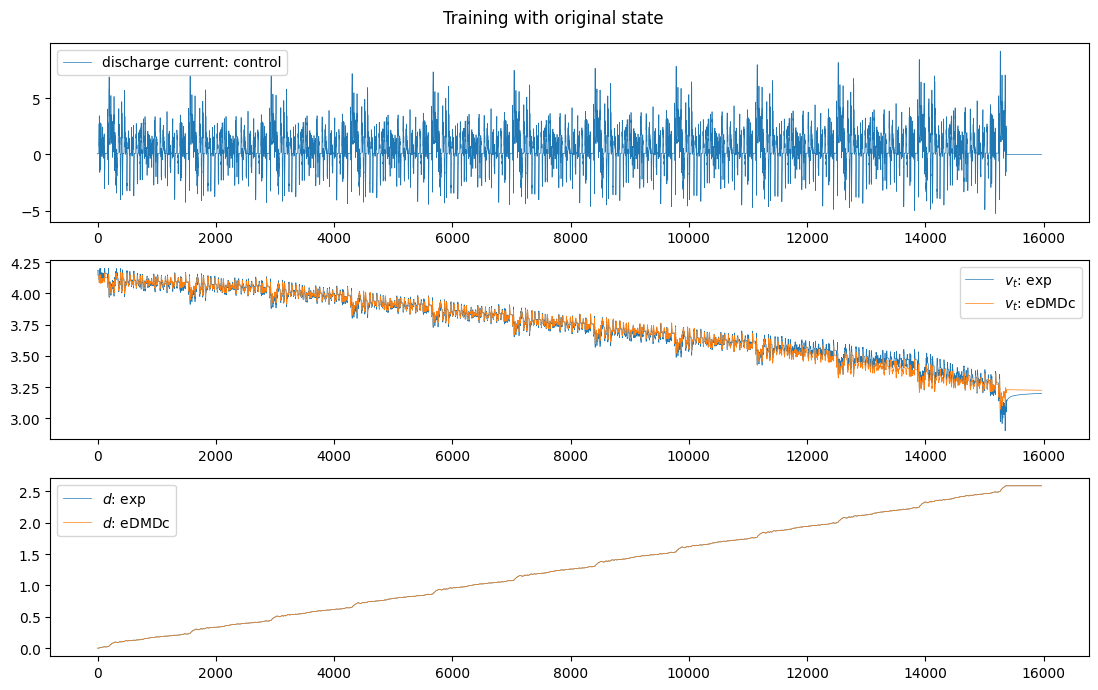

In [10]:
initial_state = state_data[0, :]

n_steps = state_data.shape[0] - 1
lw = 0.5
pred_state = model.simulate(initial_state, u=control_data[:-1], n_steps=n_steps)
pred_state = np.vstack([initial_state, pred_state])


def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state.T, state_data.T):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err


print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_train, control_data[:, 0], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[:, i], label=state_names[i] + ": eDMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with original state")
plt.tight_layout()
plt.show()

### Validation

We can test the models performance on unseen data for validation

RMS: error: [0.04698844956403497, 0.0046911295912472365]


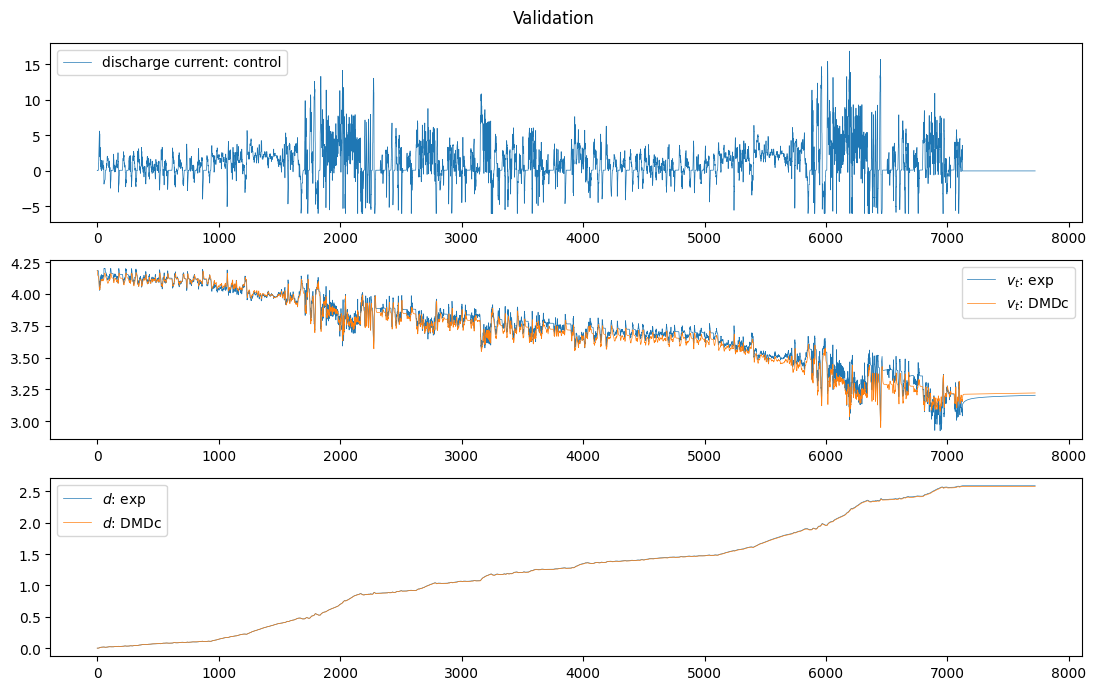

In [11]:
state_data = np.vstack([vt_val, d_val]).T
control_data = curr_val.reshape((curr_val.size, 1))

initial_state = state_data[0, :]
n_steps = state_data.shape[0] - 1
lw = 0.5
pred_state = model.simulate(initial_state, u=control_data[:-1], n_steps=n_steps)
pred_state = np.vstack([initial_state, pred_state])

print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_val, control_data[:, 0], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_val, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_val, pred_state[:, i], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Validation")
plt.tight_layout()
plt.show()

## Including the eDMDc model in Collimator

To included the extended DMDc model in Collimator, we can modify the `DiscreteLinearSystem` to the `ExtendedDiscreteLinearSystem` and account for the kernel transformations within eDMDc.

In [12]:
import collimator
from collimator.framework import LeafSystem
from collimator.library import Constant

from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple


class ExtendedDiscreteLinearSystem(LeafSystem):
    """
    System for Extended DMD with control using pykoopman model (Gaussian kernel only)
    """

    def __init__(self, A, B, centers, kernel_width, dt, initial_state, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.nx_true = initial_state.size

        self.A = A
        self.B = B
        self.nx, self.nu = B.shape
        _, self.n_centers = centers.shape
        self.dt = dt

        self.centers = centers
        self.kernel_width = kernel_width

        self.declare_input_port()

        # Generate initial augmented state
        r_sq = jnp.sum((initial_state - self.centers.T) ** 2, axis=1)
        augmented_states = jnp.exp(-self.kernel_width**2 * r_sq)
        xaug = jnp.hstack([initial_state, augmented_states])

        self.state_index = self.declare_discrete_state(default_value=xaug)

        self.declare_periodic_update(
            self._update_state,
            period=self.dt,
            offset=0.0,
        )

        self.declare_output_port(
            self._eval_output,
            default_value=initial_state,
            period=self.dt,
            offset=0.0,
            requires_inputs=False
        )

    def _eval_output(self, time, state, **params):
        xaug = state.discrete_state
        x_true = xaug[: self.nx_true]
        return x_true

    def _update_state(self, time, state, u, **params):
        xaug = state.discrete_state

        x_true = xaug[: self.nx_true]

        # Re-create the augmented state from the real state
        r_sq = jnp.sum((x_true - self.centers.T) ** 2, axis=1)
        augmented_states = jnp.exp(-self.kernel_width**2 * r_sq)
        xaug_new = jnp.hstack([x_true, augmented_states])

        y = jnp.matmul(self.A, xaug_new) + jnp.matmul(self.B, jnp.atleast_1d(u))
        return y


class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.val_array = val_array
        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=self.val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = self.val_array[index]
        return self.DiscreteStateType(index=index, source_val=source_val)

We can now include the learnt data-driven system in Collimator and simulate.

In [13]:
builder = collimator.DiagramBuilder()
initial_state = jnp.array([vt_train[0], d_train[0]])
dt = 0.1

edls = builder.add(
    ExtendedDiscreteLinearSystem(
        jnp.array(model.A),
        jnp.array(model.B),
        jnp.array(model.observables.centers),
        kernel_width,
        dt=dt,
        initial_state=initial_state,
        name="edls",
    )
)

control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], edls.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["edls"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=None, max_minor_steps_per_major_step=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), DiffraxSolver(system=Diagram(root, 2 nodes), rtol=0.001, atol=1e-06, max_steps=4096, max_step_size=None, min_step_size=None, method='default', save_steps=True, return_step_interpolant=False)
[simulator.py:394 -             simulate() ] Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=None, max_minor_steps_per_major_step=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), DiffraxSolver(

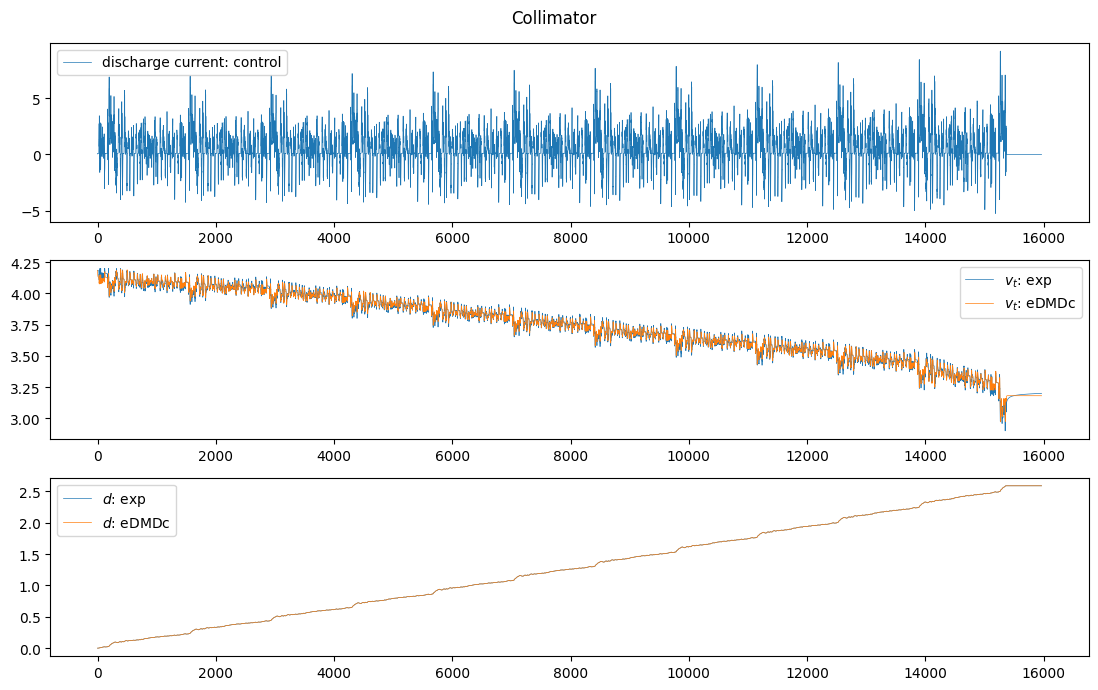

In [14]:
state_data = np.vstack([vt_train, d_train]).T  # exp data for plotting

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": eDMDc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator")
plt.tight_layout()
plt.show()